In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [23]:
# Constants
IMG_SIZE = (224, 224)  # Increased size for better feature extraction
BATCH_SIZE = 32
EPOCHS = 10  # Increased epochs with early stopping
NUM_CLASSES = 9
CLASS_NAMES = ['Atopic Dermatitis','Basal Cell Carcinoma','Benign Keratosis-like Lesions','Eczema','Melanoma','Psoriasis pictures Lichen Planus and related diseases','Seborrheic Keratoses and other Benign Tumors','Tinea Ringworm Candidiasis and other Fungal','Warts Molluscum and other Viral Infections']

In [3]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
# Path to your dataset directory 
dataset_dir ="C:/Users/MP/Videos/IMG_CLASSES"  

### Data Augumentation and Scaling

In [5]:
# Recreate generators with proper validation
train_datagen = ImageDataGenerator(
    rescale=1./127.5 - 1,
    validation_split=0.2  # 20% for validation
)

# Train generator
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',  # This is crucial
    shuffle=True
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',  # This is crucial
    shuffle=False
)

# Test generator (from separate split)
test_datagen = ImageDataGenerator(rescale=1./127.5 - 1)
test_generator = test_datagen.flow_from_directory(
    dataset_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 15350 images belonging to 9 classes.
Found 3833 images belonging to 9 classes.
Found 19183 images belonging to 9 classes.


### Tranfer Learning 

In [6]:
# Enhanced model architecture
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

In [7]:
base_model.trainable = True

In [8]:
# Unfreeze some layers for fine-tuning
for layer in base_model.layers[-20:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

In [9]:
# Add custom head
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=True)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [10]:
# Enhanced optimizer configuration
optimizer = optimizers.Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    amsgrad=False
)

In [11]:
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)


In [12]:
# Enhanced callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7),
    #ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
]

In [13]:
# Training with class weights (handle imbalanced data)
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', 
                                   classes=np.unique(train_generator.classes), 
                                   y=train_generator.classes)
class_weights = dict(enumerate(class_weights))


In [14]:
# 1. Calculate proper steps
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

# Ensure minimum 1 step
steps_per_epoch = max(1, steps_per_epoch)
validation_steps = max(1, validation_steps)

print(f"Training steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

Training steps per epoch: 479
Validation steps: 119


In [15]:
print(f"Total training samples: {train_generator.samples}")
print(f"Total validation samples: {validation_generator.samples}")

Total training samples: 15350
Total validation samples: 3833


In [16]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks,
    #class_weight=class_weights
)

Epoch 1/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 2545s 5s/step - accuracy: 0.5072 - auc: 0.8817 - loss: 1.4312 - val_accuracy: 0.2876 - val_auc: 0.6666 - val_loss: 4.0245 - learning_rate: 1.0000e-04
Epoch 2/10
  1/479 ━━━━━━━━━━━━━━━━━━━━ 39:11 5s/step - accuracy: 0.4375 - auc: 0.8766 - loss: 1.6273

C:\Users\MP\anaconda3\envs\tensorflow_env\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


479/479 ━━━━━━━━━━━━━━━━━━━━ 116s 232ms/step - accuracy: 0.4375 - auc: 0.8766 - loss: 1.6273 - val_accuracy: 0.2878 - val_auc: 0.6665 - val_loss: 4.0116 - learning_rate: 1.0000e-04
Epoch 3/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 2343s 5s/step - accuracy: 0.6383 - auc: 0.9419 - loss: 0.9704 - val_accuracy: 0.4097 - val_auc: 0.7642 - val_loss: 3.2034 - learning_rate: 1.0000e-04
Epoch 4/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 100s 201ms/step - accuracy: 0.5938 - auc: 0.9200 - loss: 1.1642 - val_accuracy: 0.4099 - val_auc: 0.7641 - val_loss: 3.2103 - learning_rate: 1.0000e-04
Epoch 5/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 2124s 4s/step - accuracy: 0.7078 - auc: 0.9599 - loss: 0.7968 - val_accuracy: 0.4438 - val_auc: 0.7935 - val_loss: 3.0813 - learning_rate: 1.0000e-04
Epoch 6/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 92s 185ms/step - accuracy: 0.6875 - auc: 0.9617 - loss: 0.7839 - val_accuracy: 0.4443 - val_auc: 0.7928 - val_loss: 3.0857 - learning_rate: 1.0000e-04
Epoch 7/10
479/479 ━━━━━━━━━━━━━━━━━━━━ 2141s 4s/step - 

In [17]:
# Evaluation
test_loss, test_acc, test_auc = model.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}')

600/600 ━━━━━━━━━━━━━━━━━━━━ 484s 806ms/step - accuracy: 0.8162 - auc: 0.9678 - loss: 0.6860

Test accuracy: 0.8162, Test AUC: 0.9678


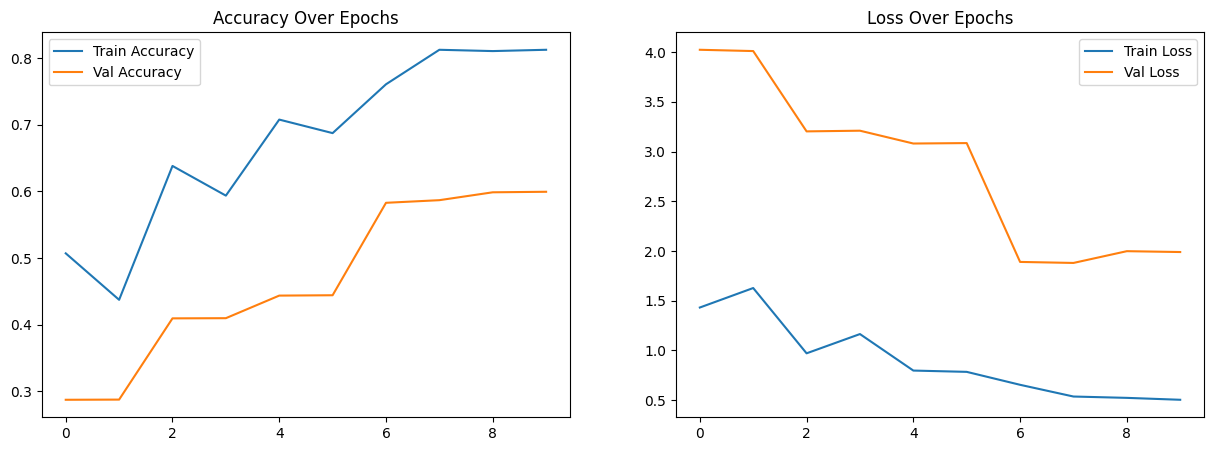

In [18]:
# Plotting
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

In [19]:
# Generate predictions
test_generator.reset()
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes


600/600 ━━━━━━━━━━━━━━━━━━━━ 477s 787ms/step


In [20]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))



Classification Report:
                                                       precision    recall  f1-score   support

                                    Atopic Dermatitis       0.52      0.80      0.63      1257
                                 Basal Cell Carcinoma       0.89      0.97      0.93      3323
                        Benign Keratosis-like Lesions       0.96      0.78      0.86      2079
                                               Eczema       0.66      0.82      0.73      1677
                                             Melanoma       0.98      0.99      0.99      3140
Psoriasis pictures Lichen Planus and related diseases       0.78      0.62      0.69      2055
         Seborrheic Keratoses and other Benign Tumors       0.96      0.59      0.73      1847
          Tinea Ringworm Candidiasis and other Fungal       0.77      0.75      0.76      1702
           Warts Molluscum and other Viral Infections       0.76      0.80      0.78      2103

                        

In [21]:
import json
# Save as .keras (includes custom loss)
model.save("best_model.keras")
print("✓ Saved: best_model.keras")


✓ Saved: best_model.keras


In [24]:

#Save class names alongside the model

metadata = {
    "class_names": CLASS_NAMES,
    "num_classes": NUM_CLASSES,
    "img_size": list(IMG_SIZE),
    "model_version": "1.0.0"
}
with open("model_metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)
print("✓ Saved: model_metadata.json")
print(f"  Classes: {CLASS_NAMES}")

✓ Saved: model_metadata.json
  Classes: ['Atopic Dermatitis', 'Basal Cell Carcinoma', 'Benign Keratosis-like Lesions', 'Eczema', 'Melanoma', 'Psoriasis pictures Lichen Planus and related diseases', 'Seborrheic Keratoses and other Benign Tumors', 'Tinea Ringworm Candidiasis and other Fungal', 'Warts Molluscum and other Viral Infections']


In [26]:
# ── Verify the saved model loads correctly ───────────────────────
print("\nVerifying saved model...")
test_model = tf.keras.models.load_model(
    "best_model.keras"
)
dummy_input = np.zeros((1, *IMG_SIZE, 3), dtype=np.float32)
test_output = test_model.predict(dummy_input, verbose=0)
print(f"Model verified: {test_output.shape}")
print(f"Expected: (1, {NUM_CLASSES})")



Verifying saved model...
Model verified: (1, 9)
Expected: (1, 9)
